# Venta de productos alimenticios

## Descripción del proyecto

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.

### Descripción de los datos


Cada entrada de registro es una acción de usuario o un evento.

EventName: nombre del evento.
DeviceIDHash: identificador de usuario unívoco.
EventTimestamp: hora del evento.
ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

## Leer archivo y preparar los datos

### Importar librerías

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt

### Leer archivo y preparar los datos

In [2]:
df_events = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

In [3]:
print(df_events.info())
print(df_events.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248


In [4]:
#Cambiar nombre de columnas
df_events.columns = ['event_name', 'device_id_hash', 'event_time_stamp', 'exp_id']
print(df_events.columns)

Index(['event_name', 'device_id_hash', 'event_time_stamp', 'exp_id'], dtype='object')


In [5]:
#corroborar nombres de events
df_events['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [6]:
#Cambiar a datetime
df_events['event_time_stamp'] = pd.to_datetime(df_events['event_time_stamp'], unit='s')
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   device_id_hash    244126 non-null  int64         
 2   event_time_stamp  244126 non-null  datetime64[ns]
 3   exp_id            244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [7]:
#Agregar columna de fecha y hora
df_events['date'] = df_events['event_time_stamp'].dt.date

print("--- Datos y Tipos de Datos (Después de la preparación) ---")
print(df_events.info())
print("\nPrimeras filas del DataFrame:")
print(df_events.head())

--- Datos y Tipos de Datos (Después de la preparación) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   device_id_hash    244126 non-null  int64         
 2   event_time_stamp  244126 non-null  datetime64[ns]
 3   exp_id            244126 non-null  int64         
 4   date              244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB
None

Primeras filas del DataFrame:
                event_name       device_id_hash    event_time_stamp  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppea

In [8]:
#Corroborar valores duplicados
print(f"\nNúmero de filas duplicadas (Eventos idénticos): {df_events.duplicated().sum()}")
df_events = df_events.drop_duplicates().reset_index(drop=True)
print(f"Total de eventos después de eliminar duplicados: {len(df_events)}")


Número de filas duplicadas (Eventos idénticos): 413
Total de eventos después de eliminar duplicados: 243713


## Estudiar y comprobar los datos

In [9]:
# 1. ¿Cuántos eventos hay en los registros?
total_events = len(df_events)
print(f"Total de eventos en los registros: {total_events}")

# 2. ¿Cuántos usuarios hay en los registros?
total_users = df_events['device_id_hash'].nunique()
print(f"Total de usuarios en los registros: {total_users}")

# 3. ¿Cuál es el promedio de eventos por usuario?
avg_events_per_user = total_events / total_users
print(f"Promedio de eventos por usuario: {avg_events_per_user:.2f}")


Total de eventos en los registros: 243713
Total de usuarios en los registros: 7551
Promedio de eventos por usuario: 32.28


Fecha mínima (inicio del registro): 2019-07-25 04:43:36
Fecha máxima (fin del registro): 2019-08-07 21:15:17


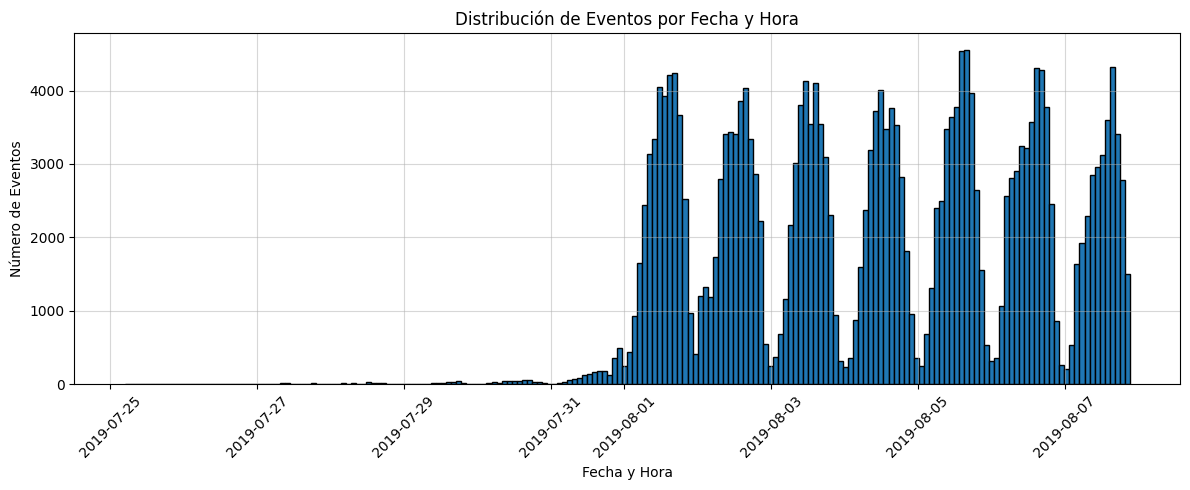

In [10]:
# 4. ¿Qué periodo de tiempo cubren los datos?
min_date = df_events['event_time_stamp'].min()
max_date = df_events['event_time_stamp'].max()
print(f"Fecha mínima (inicio del registro): {min_date}")
print(f"Fecha máxima (fin del registro): {max_date}")

#Trazar un histograma por fecha y hora para verificar la completitud
plt.figure(figsize=(12, 5))
df_events['event_time_stamp'].hist(bins=200, edgecolor='black')
plt.title('Distribución de Eventos por Fecha y Hora')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Eventos')
plt.grid(True, alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Filtrado de datos por período completo ---
# El histograma muestra que los datos se vuelven completos a partir del 1 de agosto de 2019.
# Vamos a usar esa fecha como nuestro punto de corte (start_date).
start_date = dt.datetime(2019, 8, 1)

events_before_filtering = len(df_events)
users_before_filtering = df_events['device_id_hash'].nunique()

df_events_filtered = df_events[df_events['event_time_stamp'] >= start_date].copy()

Observamos que nuestra fecha de corta debe ser 01-08-2019, ya que a partir de esa fecha observamos distribución de los datos

In [11]:
# 6. ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
events_after_filtering = len(df_events_filtered)
users_after_filtering = df_events_filtered['device_id_hash'].nunique()

events_lost_percent = ((events_before_filtering - events_after_filtering) / events_before_filtering) * 100
users_lost_percent = ((users_before_filtering - users_after_filtering) / users_before_filtering) * 100

print(f"\n--- Filtrado de Datos ---")
print(f"Se ignorarán los datos anteriores a: {start_date.strftime('%Y-%m-%d')}")
print(f"Eventos perdidos: {events_lost_percent:.2f}%")
print(f"Usuarios perdidos: {users_lost_percent:.2f}%")

# ¿Qué periodo representan realmente los datos?
real_min_date = df_events_filtered['event_time_stamp'].min()
real_max_date = df_events_filtered['event_time_stamp'].max()
print(f"Período de análisis real: Del {real_min_date.strftime('%Y-%m-%d')} al {real_max_date.strftime('%Y-%m-%d')}")

# 7. Asegurarse de tener usuarios de los tres grupos experimentales (con datos filtrados)
exp_users = df_events_filtered.groupby('exp_id')['device_id_hash'].nunique()
print(f"\nUsuarios por grupo experimental (después del filtrado):")
print(exp_users)


# --- Preparación final para el embudo (Paso 4) ---
# Creamos un DF que asocia cada usuario con su grupo de experimento
user_groups = df_events_filtered[['device_id_hash', 'exp_id']].drop_duplicates()
# Verificamos que no haya usuarios en varios grupos (contaminación)
user_contamination = user_groups.groupby('device_id_hash').filter(lambda x: len(x) > 1)['device_id_hash'].nunique()
print(f"\nUsuarios contaminados (en múltiples grupos): {user_contamination}")

# Los eliminamos del set de datos filtrado
if user_contamination > 0:
    contaminated_users = user_groups.groupby('device_id_hash').filter(lambda x: len(x) > 1)['device_id_hash'].unique()
    df_events_clean = df_events_filtered[~df_events_filtered['device_id_hash'].isin(contaminated_users)].copy()
else:
    df_events_clean = df_events_filtered.copy()

print(f"Usuarios finales para el análisis: {df_events_clean['device_id_hash'].nunique()}")
print(f"Eventos finales para el análisis: {len(df_events_clean)}")


--- Filtrado de Datos ---
Se ignorarán los datos anteriores a: 2019-08-01
Eventos perdidos: 1.16%
Usuarios perdidos: 0.23%
Período de análisis real: Del 2019-08-01 al 2019-08-07

Usuarios por grupo experimental (después del filtrado):
exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Usuarios contaminados (en múltiples grupos): 0
Usuarios finales para el análisis: 7534
Eventos finales para el análisis: 240887


## Estudiar el embudo de eventos

In [12]:
# 1. Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
events_frequency = df_events_clean.groupby('event_name')['event_name'].count().sort_values(ascending=False).rename('event_count')
print("\nEventos por frecuencia de suceso:")
print(events_frequency)

# 2. Encuentra la cantidad de usuarios que realizaron cada una de estas acciones.
users_by_event = df_events_clean.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).rename('users_count')

# 3. Combina los datos de eventos y usuarios
funnel_data = pd.concat([events_frequency, users_by_event], axis=1)

# AGREGAR ESTA LÍNEA:
total_users_final_analysis = df_events_clean['device_id_hash'].nunique()

# 4. Calcula la proporción de usuarios que realizaron la acción al menos una vez.
funnel_data['user_share'] = funnel_data['users_count'] / total_users_final_analysis
funnel_data['user_share'] = funnel_data['user_share'].map('{:.2%}'.format)

print("\nUsuarios únicos por evento y proporción (orden descendente):")
print(funnel_data.sort_values(by='users_count', ascending=False))



Eventos por frecuencia de suceso:
event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_count, dtype: int64

Usuarios únicos por evento y proporción (orden descendente):
                         event_count  users_count user_share
event_name                                                  
MainScreenAppear              117328         7419     98.47%
OffersScreenAppear             46333         4593     60.96%
CartScreenAppear               42303         3734     49.56%
PaymentScreenSuccessful        33918         3539     46.97%
Tutorial                        1005          840     11.15%


In [13]:
# --- Embudo de Conversión (Asumiendo un orden lógico) ---

# Orden Lógico Asumido:
# 1. MainScreenAppear (Inicio)
# 2. OffersScreenAppear (Visualización de ofertas / catálogo)
# 3. CartScreenAppear (Agregar al carrito)
# 4. PaymentScreenSuccessful (Compra / Pago)

event_order = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Creamos un DF con solo los eventos del embudo
funnel_df = funnel_data.loc[event_order].copy()
funnel_df = funnel_df.rename_axis('funnel_step')
funnel_df

,event_count,users_count,user_share
funnel_step,,,
MainScreenAppear,117328,7419,98.47%
OffersScreenAppear,46333,4593,60.96%
CartScreenAppear,42303,3734,49.56%
PaymentScreenSuccessful,33918,3539,46.97%


En esta DF observamos el embudo al corroborar cómo los porcentajes se van reduciendo de un evento a otro.

In [14]:
# 5. Calcular la proporción de usuarios que pasan de una etapa a la siguiente

# Agregamos la columna de total de usuarios (ya ordenada por el embudo)
funnel_df['total_users'] = funnel_df['users_count']

# Tasa de abandono (Drop-off Rate)
funnel_df['drop_off_rate'] = (funnel_df['total_users'].shift(1) - funnel_df['total_users']) / funnel_df['total_users'].shift(1)
funnel_df['drop_off_rate'] = funnel_df['drop_off_rate'].fillna(0).map('{:.2%}'.format)

# Tasa de conversión de paso a paso (Step-to-Step Conversion)
funnel_df['step_conversion'] = funnel_df['total_users'] / funnel_df['total_users'].shift(1)
funnel_df['step_conversion'] = funnel_df['step_conversion'].fillna(1).map('{:.2%}'.format)

# Tasa de conversión acumulada (Overall Conversion)
funnel_df['overall_conversion'] = funnel_df['total_users'] / funnel_df['total_users'].iloc[0]
funnel_df['overall_conversion'] = funnel_df['overall_conversion'].map('{:.2%}'.format)

# Mostrar el embudo
print("\nAnálisis del Embudo de Conversión:")
print(funnel_df[['total_users', 'step_conversion', 'drop_off_rate', 'overall_conversion']])


Análisis del Embudo de Conversión:
                         total_users step_conversion drop_off_rate  \
funnel_step                                                          
MainScreenAppear                7419         100.00%         0.00%   
OffersScreenAppear              4593          61.91%        38.09%   
CartScreenAppear                3734          81.30%        18.70%   
PaymentScreenSuccessful         3539          94.78%         5.22%   

                        overall_conversion  
funnel_step                                 
MainScreenAppear                   100.00%  
OffersScreenAppear                  61.91%  
CartScreenAppear                    50.33%  
PaymentScreenSuccessful             47.70%  



Porcentaje de usuarios que hacen el viaje completo (desde el primer paso hasta el pago): 47.70%


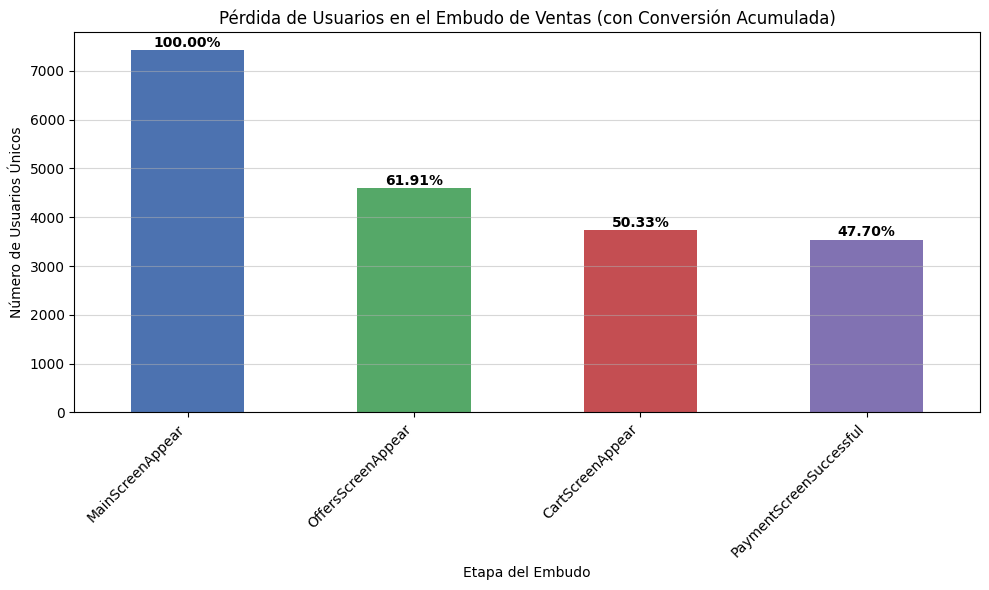

In [15]:
# 6. ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?
initial_users = funnel_df.loc['MainScreenAppear', 'total_users']
final_users = funnel_df.loc['PaymentScreenSuccessful', 'total_users']
total_conversion = final_users / initial_users
print(f"\nPorcentaje de usuarios que hacen el viaje completo (desde el primer paso hasta el pago): {total_conversion:.2%}")

# Gráfico de Embudo (Visualización de la pérdida de usuarios con etiquetas de porcentaje)
plt.figure(figsize=(10, 6))
bars = funnel_df['total_users'].plot(kind='bar', color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])

# Función para añadir etiquetas de porcentaje en la parte superior de cada barra
for i, bar in enumerate(bars.patches):
    # Porcentaje de conversión acumulada (ya es string)
    conversion_rate = funnel_df['overall_conversion'].iloc[i]
    yval = bar.get_height()
    
    # Usar directamente la cadena (ya tiene formato de porcentaje)
    percentage_text = conversion_rate
    
    # Agregar el texto al gráfico
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, percentage_text, ha='center', va='bottom', fontsize=10, weight='bold')


plt.title('Pérdida de Usuarios en el Embudo de Ventas (con Conversión Acumulada)')
plt.xlabel('Etapa del Embudo')
plt.ylabel('Número de Usuarios Únicos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

Observamos cómo el porcentaje de los usuarios que pasan de una etapa a otra va disminuyendo. Vemos la mayor pérdida de usuarios con una caída del 38% de la pantalla principal a la pantalla de ofertas, después de eso los usuarios disminuyen muy poco. Para finalmente quedarnos con el 47% de los usuarios que realizan el pago exitosamente. 

## Estudiar los resultados del experimento 

In [16]:
# 1. Conteo de usuarios por grupo
users_by_group = df_events_clean.groupby('exp_id')['device_id_hash'].nunique()
print("\nUsuarios únicos por grupo (246 y 247: Control A/A, 248: Prueba B):")
print(users_by_group)

# Definición de variables clave
alpha = 0.05
events_list = df_events_clean['event_name'].unique()
total_tests = len(events_list) * 4 # 5 eventos * 4 comparaciones
alpha_bonferroni = 0.05 / total_tests

group_246_users = users_by_group.loc[246]
group_247_users = users_by_group.loc[247]
group_248_users = users_by_group.loc[248]
group_control_combined_users = group_246_users + group_247_users


Usuarios únicos por grupo (246 y 247: Control A/A, 248: Prueba B):
exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


In [17]:
# 2. Definición de la función para la prueba de proporciones (para reutilizarla)
def check_significance(group1_users, group2_users, group1_id, group2_id, event_name, alpha=0.05):
    """
    Realiza la prueba Z para la diferencia entre dos proporciones.
    Compara dos grupos individuales.
    """
    
    # Éxitos: Usuarios únicos que realizaron el evento en cada grupo
    successes = np.array([
        df_events_clean[df_events_clean['exp_id'] == group1_id].groupby('event_name')['device_id_hash'].nunique().get(event_name, 0),
        df_events_clean[df_events_clean['exp_id'] == group2_id].groupby('event_name')['device_id_hash'].nunique().get(event_name, 0)
    ])
    
    # Muestras: Total de usuarios únicos en cada grupo
    samples = np.array([group1_users, group2_users])
    
    # Prueba Z para proporciones
    z_stat, p_value = proportions_ztest(successes, samples, alternative='two-sided')
    
    # Calculamos la proporción relativa (Grupo 2 vs Grupo 1)
    prop1 = successes[0] / samples[0]
    prop2 = successes[1] / samples[1]
    
    relative_diff = (prop2 / prop1 - 1) * 100 if prop1 != 0 else np.nan
        
    return p_value, relative_diff

def check_significance_combined(group_control_combined_users, group2_users, event_name, alpha=0.05):
    """
    Realiza la prueba Z comparando el grupo combinado (246+247) vs el grupo de prueba (248).
    """
    
    # Éxitos combinados del control
    successes_246 = df_events_clean[df_events_clean['exp_id'] == 246].groupby('event_name')['device_id_hash'].nunique().get(event_name, 0)
    successes_247 = df_events_clean[df_events_clean['exp_id'] == 247].groupby('event_name')['device_id_hash'].nunique().get(event_name, 0)
    successes_248 = df_events_clean[df_events_clean['exp_id'] == 248].groupby('event_name')['device_id_hash'].nunique().get(event_name, 0)
    
    successes_combined = successes_246 + successes_247
    
    # Arrays para la prueba Z
    successes = np.array([successes_combined, successes_248])
    samples = np.array([group_control_combined_users, group_248_users])
    
    z_stat, p_value = proportions_ztest(successes, samples, alternative='two-sided')
    
    # Calculamos la proporción relativa (Grupo 248 vs Combinado)
    prop1 = successes_combined / group_control_combined_users
    prop2 = successes_248 / group_248_users
    
    relative_diff = (prop2 / prop1 - 1) * 100 if prop1 != 0 else np.nan
        
    return p_value, relative_diff

### Prueba A/A

In [18]:
# --- 3. Test A/A: Comprobamos si hay diferencia entre los grupos de control 246 y 247.
print(f"\n--- Test A/A (Grupos de Control 246 vs 247) con Bonferroni $\\alpha={alpha_bonferroni:.4f}$ ---")
aa_results = {}
for event in events_list:
    p_value, relative_diff = check_significance(group_246_users, group_247_users, 246, 247, event, alpha_bonferroni)
    aa_results[event] = {'p_value': p_value, 'relative_diff': relative_diff}

aa_summary = pd.DataFrame(aa_results).T
aa_summary['significant_bonf'] = aa_summary['p_value'] < alpha_bonferroni
print("\n--- Resumen del Test A/A ---")
print(aa_summary.round(4)) 
print(f"Conclusión A/A: Hay {aa_summary['significant_bonf'].sum()} evento(s) con diferencia significativa al aplicar Bonferroni. Esto confirma que los grupos de control son similares.")


--- Test A/A (Grupos de Control 246 vs 247) con Bonferroni $\alpha=0.0025$ ---

--- Resumen del Test A/A ---
                         p_value  relative_diff  significant_bonf
Tutorial                  0.9377         0.6238             False
MainScreenAppear          0.7571        -0.1050             False
OffersScreenAppear        0.2481        -2.5643             False
CartScreenAppear          0.2288        -3.3402             False
PaymentScreenSuccessful   0.1146        -4.6136             False
Conclusión A/A: Hay 0 evento(s) con diferencia significativa al aplicar Bonferroni. Esto confirma que los grupos de control son similares.


#### Conclusión

Con esto comprobamos que no existe ninguna diferencia significativamente estadística entre el grupo AA lo cual es esperado ya que ambos grupos están viendo la misma versión de la aplicación. Este resultado nos confirma que el mecanismo de asignación de usuarios está funcionado correctamente y podemos continuar con la prueba A/B

### Prueba A/B

#### Prueba A-B individual

In [19]:
# Comparación A vs B (246 vs 248)
print(f"\n--- Test A/B (Grupo de Prueba 248 vs Control 246) con Bonferroni $\\alpha={alpha_bonferroni:.4f}$ ---")
ab_246_results = {}
for event in events_list:
    p_value, relative_diff = check_significance(group_246_users, group_248_users, 246, 248, event, alpha_bonferroni)
    ab_246_results[event] = {'p_value': p_value, 'relative_diff': relative_diff}

ab_246_summary = pd.DataFrame(ab_246_results).T
ab_246_summary['significant_bonf'] = ab_246_summary['p_value'] < alpha_bonferroni
print("\n--- Resumen del Test A/B (246 vs 248) ---")
print(ab_246_summary.to_string(float_format='%.4f'))



--- Test A/B (Grupo de Prueba 248 vs Control 246) con Bonferroni $\alpha=0.0025$ ---

--- Resumen del Test A/B (246 vs 248) ---
                         p_value  relative_diff  significant_bonf
Tutorial                  0.8264        -1.7369             False
MainScreenAppear          0.2950        -0.3706             False
OffersScreenAppear        0.2084        -2.7875             False
CartScreenAppear          0.0784        -4.8733             False
PaymentScreenSuccessful   0.2123        -3.6393             False


Conclusión: No encontramos diferencia estadísticamente significativa en ninguno de los eventos. 

In [20]:
# Comparación A vs B (247 vs 248)
print(f"\n--- Test A/B (Grupo de Prueba 248 vs Control 247) con Bonferroni $\\alpha={alpha_bonferroni:.4f}$ ---")
ab_247_results = {}
for event in events_list:
    p_value, relative_diff = check_significance(group_247_users, group_248_users, 247, 248, event, alpha_bonferroni)
    ab_247_results[event] = {'p_value': p_value, 'relative_diff': relative_diff}

ab_247_summary = pd.DataFrame(ab_247_results).T
ab_247_summary['significant_bonf'] = ab_247_summary['p_value'] < alpha_bonferroni
print("\n--- Resumen del Test A/B (247 vs 248) ---")
print(ab_247_summary.to_string(float_format='%.4f'))


--- Test A/B (Grupo de Prueba 248 vs Control 247) con Bonferroni $\alpha=0.0025$ ---

--- Resumen del Test A/B (247 vs 248) ---
                         p_value  relative_diff  significant_bonf
Tutorial                  0.7653        -2.3461             False
MainScreenAppear          0.4587        -0.2659             False
OffersScreenAppear        0.9198        -0.2292             False
CartScreenAppear          0.5786        -1.5861             False
PaymentScreenSuccessful   0.7373         1.0214             False


Conclusión: No encontramos diferencia estadísticamente significativa en ninguno de los eventos.

#### Prueba A/B combinada

In [21]:
# --- 5. Test A/B (Combinado) ---
print(f"\n--- Test A/B (Grupo de Prueba 248 vs Control Combinado (246+247)) con Bonferroni $\\alpha={alpha_bonferroni:.4f}$ ---")
ab_combined_results = {}
for event in events_list:
    p_value, relative_diff = check_significance_combined(group_control_combined_users, group_248_users, event, alpha_bonferroni)
    ab_combined_results[event] = {'p_value': p_value, 'relative_diff': relative_diff}

ab_combined_summary = pd.DataFrame(ab_combined_results).T
ab_combined_summary['significant_bonf'] = ab_combined_summary['p_value'] < alpha_bonferroni
print("\n--- Resumen del Test A/B (246+247 vs 248) ---")
print(ab_combined_summary.to_string(float_format='%.4f'))


--- Test A/B (Grupo de Prueba 248 vs Control Combinado (246+247)) con Bonferroni $\alpha=0.0025$ ---

--- Resumen del Test A/B (246+247 vs 248) ---
                         p_value  relative_diff  significant_bonf
Tutorial                  0.7649        -2.0442             False
MainScreenAppear          0.2942        -0.3180             False
OffersScreenAppear        0.4343        -1.5175             False
CartScreenAppear          0.1818        -3.2481             False
PaymentScreenSuccessful   0.6004        -1.3505             False


Conclusión: No encontramos diferencia estadísticamente significativa en ninguno de los eventos.

### Conclusión final

Para establecer un valor alfa confiable utilizamos la corrección de Bonferroni. Ya que si elegíamos un valor alfa del 0.05, al ser 20 pruebas aumenta el riesgo de falsos positivos y deja de ser 95% confiable. Por lo tanto al hacer esta corrección y divididr el valor alfa de 0.05 que establecimos como inicial, entre la cantidad de pruebas (20), establecimos un nivel de significancia de 0.0025. Esto nos permite que nuestro nivel de confianza siga siendo 95%. Sin embargo, ningún valor de P fue menos a 0.0025, de hecho podemos observar que en todas las pruebas nuestro valor de P se acerca mucho al 1. Por lo tanto podemos afirmar que no existe diferencia significativa en ninguno de los grupos. Esto quiere decir que el equipo de diseño puede cambiar las fuentes de la aplicación, ya que a la gente no le parecen intimidantes. Pues no hubo ninguna diferencia entre los grupos que tenían la fuente antigua y la nueva en ninguno de los eventos. Podemos dar por concluída la prueba y finalizarla. 